In [1]:
import ExonExonData as eed
import pathlib
cwd = pathlib.Path.cwd()
import pandas
import numpy
import pickle
from Heatmaps import heat_embedding
from Heatmaps import heatmapv2 as heatmap
from Heatmaps import _undigitize_seq as undigit
from Heatmaps import _reorder_frame as reorder_frame
from Heatmaps import _import_data
from MomentCalculations import _unrenormalize
from MomentCalculations import moment
from MomentCalculations import multiple_species_plots
from typing import Tuple
import re

In [2]:
def moments_generic(file: pathlib.Path, 
                    ms: list, 
                    k: int = 1, 
                    unlog: bool = False, logy: bool = False, N_value: bool = False, 
                    *args, **kwargs) -> list:
    '''
    Just does one moment calulation at a time
    '''
    return_list = list()

    if isinstance(file, pathlib.Path):
        data = _import_data(file, just_import = True, *args, **kwargs)
        data = pandas.DataFrame(data)
    elif isinstance(file, pandas.DataFrame):
        data = file
    
    if unlog:
        data = _unrenormalize(data, 2*k, *args, **kwargs)
    
    for m in ms:

        if N_value:
            N = 4**(2*k)
            N = N**((1/m) - 1)
            print(f"\t\tm = {m}\tN = {N}")
        else:
            N = 1
            print(f"\t\tm = {m}")

        data_v = moment(data, m = m, unlog = False, N = N, *args, **kwargs)

        if logy:
            data_v = numpy.log2(data_v)

        return_list.append(data_v)

    return return_list

    # return me, mi, mn, uni, pd

Not really in need of fixing but I'll keep up the convention.

Creates a heatmap for all the Exon2Exon comparisions.

In [3]:
def heat_dataset(source_data: pathlib.Path or pandas.DataFrame, length: int = 12, join_seq: list = None, sheet_name: str = "sheet1", *args, **kwargs) -> pandas.DataFrame:
    '''
    I have lost how I originally created the dataset for the heatmaps, so here's a function for doing that.

    This assumes the data is a pickle or a dataframe.

    Except never mind, the frame data will work nicely. I'm just going to use this to filter down to a nice length for the sequences
    '''
    if isinstance(source_data, pathlib.Path):
        if source_data.suffix in ".pkl":
            source_data: pandas.DataFrame = pandas.read_pickle(source_data)
        elif source_data.suffix in ".csv":
            source_data: pandas.DataFrame = pandas.read_csv(source_data)
        elif source_data.suffix in ".xlsx":
            source_data: pandas.DataFrame = pandas.read_excel(source_data, sheet_name = sheet_name)

    if isinstance(join_seq, list):
        source_data["Seq"] = source_data[join_seq[0]] + source_data[join_seq[1]]

    source_data["Length"] = source_data["Seq"].apply(lambda x: len(x))
    source_data = source_data[source_data["Length"] >= length]
    source_data = source_data.reset_index() 

    return source_data

In [4]:
cancer_folder = cwd / "Dicts_Cancer"
cancer_folder.mkdir(parents = True, exist_ok = True)

In [5]:
normal_data = cwd.parent / "Data_Files" / "Primates" / "Genetics" / "Homo_Sapiens" / "G_Data" / "Normal_Exon2Exon.xlsx"
normal_data = pandas.read_excel(normal_data, sheet_name="sheet1")

normal_data["Posterior"] = normal_data["Posterior_20"].apply(lambda x: x[len(x) - 6: len(x)])
normal_data["Anterior"] = normal_data["Anterior_20"].apply(lambda x: x[0: 6])
normal_data["Seq"] = normal_data["Posterior"] + normal_data["Anterior"]
normal_data["Classificaion"] = "exon"

print(normal_data.head())

             Name  Chrm Strand          Posterior_20           Anterior_20  \
0  NM_001375617.1  chr1      +  TCAGTGTGGAGGAGACTGAG  TATTCTACCTTGTAAATACT   
1  NM_001375617.1  chr1      +  AGCACAAGCAGCGGCCACAG  GCCACTGCAGAACAAATTAG   
2  NM_001375617.1  chr1      +  TTGAGGAGAAGGTGAAACAA  TTGATTGATATTACAGGCAA   
3  NM_001375617.1  chr1      +  TGGAAGGAAACCCAGACACG  CATTCCTGGGAGATGGTCGG   
4  NM_001375617.1  chr1      +  TTTATCAAAACCAGCTGTGG  TTCGAGGTCAGGAAAATGGA   

  Posterior Anterior           Seq Classificaion  
0    ACTGAG   TATTCT  ACTGAGTATTCT          exon  
1    CCACAG   GCCACT  CCACAGGCCACT          exon  
2    AAACAA   TTGATT  AAACAATTGATT          exon  
3    GACACG   CATTCC  GACACGCATTCC          exon  
4    CTGTGG   TTCGAG  CTGTGGTTCGAG          exon  


In [6]:
transform = None

_, normal_exon, *_ = heat_embedding(normal_data,
                                    # n = n,
                                    # k_m = k, k_p = k,
                                    just_import = True,
                                    log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.


In [7]:
cancer_data = cwd.parent / "Data_Files" / "UTData_fs.pkl"
cancer_data: pandas.DataFrame = pandas.read_pickle(cancer_data)

cancer_data["HType"] = cancer_data["Head"].apply(lambda x: type(x)).astype(str)  # "<class 'str'>" or "<class 'float'>"
cancer_data["TType"] = cancer_data["Tail"].apply(lambda x: type(x)).astype(str)

cancer_data = cancer_data[(cancer_data["HType"] == "<class 'str'>") & (cancer_data["TType"] == "<class 'str'>")]
cancer_data = cancer_data.reset_index()

cancer_data["HLen"] = cancer_data["Head"].apply(lambda x: len(x))  # you know if I actually looked at the data I think I could have avoided this chunk
cancer_data["TLen"] = cancer_data["Tail"].apply(lambda x: len(x))
cancer_data = cancer_data[(cancer_data["HLen"] > 0) & (cancer_data["TLen"] > 0)]
cancer_data = cancer_data.reset_index()

cancer_data["Posterior"] = cancer_data["Head"].apply(lambda x: x[len(x) - 6: len(x)])
cancer_data["Anterior"] = cancer_data["Tail"].apply(lambda x: x[0: 6])
cancer_data["Seq"] = cancer_data["Posterior"] + cancer_data["Anterior"]
cancer_data["SLen"] = cancer_data["Seq"].apply(lambda x: len(x))
cancer_data = cancer_data[cancer_data["SLen"] > 11]
# cancer_data = cancer_data.reset_index()
cancer_data["Classificaion"] = "exon"

# print(cancer_data.head())
print(cancer_data["Seq"].head())
# print(cancer_data.columns)
# print(cancer_data["TType"].unique())

0    CCTCAGGGAGTA
1    CCTCAGGGAGTA
2    AAAAAGTTCTCT
3    AAAAAGTTCTCT
4    AAAAAGTTCTCT
Name: Seq, dtype: object


In [8]:
_, cancer_exon, *_ = heat_embedding(cancer_data,
                                    # n = n,
                                    # k_m = k, k_p = k,
                                    just_import = True,
                                    log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.


<class 'KeyError'>
1987
1987


In [9]:
lab_data = cwd.parent / "Data_Files" / "Fullfusionlist.pkl"
lab_data: pandas.DataFrame = pandas.read_pickle(lab_data)

# print(lab_data.head())
lab_data["Posterior"] = lab_data["Head"].apply(lambda x: x[len(x) - 6: len(x)])
lab_data["Anterior"] = lab_data["Tail"].apply(lambda x: x[0: 6])
lab_data["Posterior"] = lab_data["Posterior"].apply(lambda x: pandas.NA if re.search(r"(\_|\?|\.)", x) else x)
lab_data["Anterior"] = lab_data["Anterior"].apply(lambda x: pandas.NA if re.search(r"(\_|\?|\.)", x) else x)

lab_data = lab_data.dropna()
lab_data = lab_data.reset_index()
lab_data["Seq"] = lab_data["Posterior"] + lab_data["Anterior"]
lab_data["SLen"] = lab_data["Seq"].apply(lambda x: len(x))

lab_data = lab_data[lab_data["SLen"] > 11]

lab_data["Classificaion"] = "exon"


In [10]:
_, lab_exon, *_ = heat_embedding(lab_data,
                                 # n = n,
                                 # k_m = k, k_p = k,
                                 just_import = True,
                                 log_transform = transform)  # Just import is turned on because I have one dictionary with all the data. I'll use that one set for all the images from now on. Just makes things a little faster and easier.


<class 'KeyError'>
149
149
<class 'KeyError'>
826
826
<class 'KeyError'>
2290
2290
<class 'KeyError'>
3850
3850
<class 'KeyError'>
4114
4114
<class 'KeyError'>
4254
4254
<class 'KeyError'>
4364
4364
<class 'KeyError'>
4476
4476
<class 'KeyError'>
4501
4501
<class 'KeyError'>
4607
4607
<class 'KeyError'>
5026
5026
<class 'KeyError'>
5027
5027
<class 'KeyError'>
5196
5196
<class 'KeyError'>
5202
5202


In [11]:
normal_frame = reorder_frame(pandas.DataFrame(normal_exon), transpose = False)
cancer_frame = reorder_frame(pandas.DataFrame(cancer_exon), transpose = False)
lab_frame = reorder_frame(pandas.DataFrame(lab_exon), transpose = False)

In [12]:
# print(normal_frame)
new_names = {x: undigit(x) for x in list(normal_frame.columns)}
# print(new_names)
normal_frame = normal_frame.rename(new_names, axis=1)
normal_frame = normal_frame.rename(new_names, axis=0)
cancer_frame = cancer_frame.rename(new_names, axis=1)
cancer_frame = cancer_frame.rename(new_names, axis=0)
lab_frame = lab_frame.rename(new_names, axis=1)
lab_frame = lab_frame.rename(new_names, axis=0)

# print(normal_frame)

In [13]:
# normal_frame.to_excel(cwd / "WTF.xlsx")

In [14]:
with open(cancer_folder / "Normal_Exon.pkl", "wb") as file:
    pickle.dump(normal_frame, file)

with open(cancer_folder / "Cancer_Exon.pkl", "wb") as file:
    pickle.dump(cancer_frame, file)

with open(cancer_folder / "Lab_Exon.pkl", "wb") as file:
    pickle.dump(lab_frame, file)

In [15]:
normal_log = numpy.log10(normal_frame + 1)
cancer_log = numpy.log10(cancer_frame + 1)
lab_log = numpy.log10(lab_frame + 1)

Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Heatmaps\Cancer\Normal_Exon.png
Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Heatmaps\Cancer\Cancer_Exon.png
Output file to
	d:\Coding\Thesis\FractalDimension\TE_Images_ForPaper\Heatmaps\Cancer\Lab_Exon.png


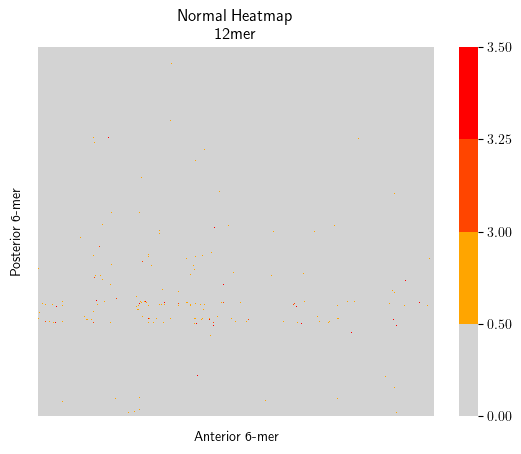

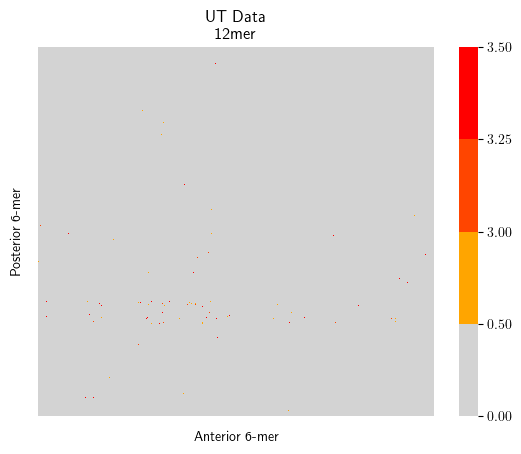

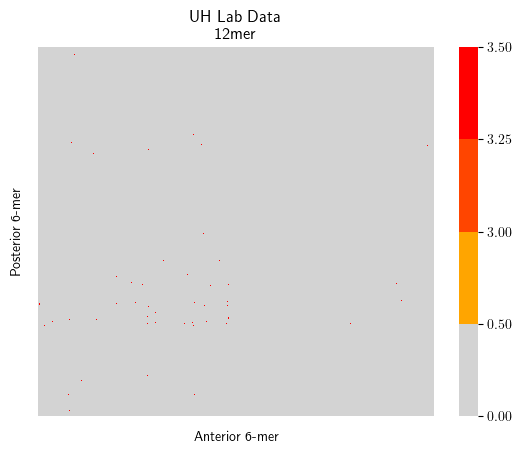

In [16]:
k = 6
# colors: list = ['darkred', 'orangered', 'green', 'lime']
colors: list = ['lightgrey', 'orange', 'orangered', 'red']
# bounds: list = [0, 0.00001, 0.0001, 0.001, 2.0] # 0.98
bounds: list = [0, 0.5, 3.0, 3.25, 3.5] # 0.98

heatmap(normal_log, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"Normal Heatmap\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Heatmaps" / "Cancer" / f"Normal_Exon.png")
heatmap(cancer_log, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"UT Data\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Heatmaps" / "Cancer" / f"Cancer_Exon.png")
heatmap(lab_log, colors = colors, bounds = bounds, 
        x_title = f"Anterior {k}-mer", y_title = f"Posterior {k}-mer",
        title = f"UH Lab Data\n{2*k}mer", fileoutput = cwd / "TE_Images_ForPaper" / "Heatmaps" / "Cancer" / f"Lab_Exon.png")


In [17]:
print(normal_log.min().min())
print(normal_log.max().max())

print(cancer_log.min().min())
print(cancer_log.max().max())


0.0
4.741587131919346
0.0
4.840371984671433


In [18]:
# Do the moments, but I think I need to modify those so that it's more general then grabbing the intron and exon.
step = 100
max_n = 2
min_n = 0.5
ms = [n / step for n in range(int(step*(min_n)), int(step*max_n) + 1)]

In [19]:
normal_frame = _unrenormalize(normal_frame, 12, log2 = False)
normal_moments = moments_generic(normal_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

In [20]:
cancer_frame = _unrenormalize(cancer_frame, 12, log2 = False)
cancer_moments = moments_generic(cancer_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

In [21]:
lab_frame = _unrenormalize(lab_frame, 12, log2 = False)
lab_moments = moments_generic(lab_frame, ms, k = 6, N_value = True)

		m = 0.5	N = 16777216.0
		m = 0.51	N = 8737708.39987156
		m = 0.52	N = 4666295.220317386
		m = 0.53	N = 2551685.0992082297
		m = 0.54	N = 1426891.7352228423
		m = 0.55	N = 814956.5606571109
		m = 0.56	N = 474860.0484895941
		m = 0.57	N = 281985.8330341041
		m = 0.58	N = 170487.96140090268
		m = 0.59	N = 104849.9103044397
		m = 0.6	N = 65536.00000000009
		m = 0.61	N = 41599.03078782457
		m = 0.62	N = 26795.02272868485
		m = 0.63	N = 17502.07186230314
		m = 0.64	N = 11585.237502960395
		m = 0.65	N = 7766.650997466475
		m = 0.66	N = 5270.1794222466315
		m = 0.67	N = 3617.796446487984
		m = 0.68	N = 2511.1241589963333
		m = 0.69	N = 1761.5243417926727
		m = 0.7	N = 1248.2699819053835
		m = 0.71	N = 893.1860454584129
		m = 0.72	N = 645.0795775461745
		m = 0.73	N = 470.06365576289903
		m = 0.74	N = 345.4737853511545
		m = 0.75	N = 255.9999999999997
		m = 0.76	N = 191.20114709177446
		m = 0.77	N = 143.89086245194235
		m = 0.78	N = 109.07909074285735
		m = 0.79	N = 83.27126499963866
		m = 0.8

In [22]:
print(min(normal_moments))
print(max(normal_moments))
print(min(cancer_moments))
print(max(cancer_moments))

0.0010396381411114637
45.88196234917515
0.00041711902206099314
73.73789826572975


In [23]:
uni = {6: [1 for _ in range(len(normal_moments))]}

Species = Normal
plotting for 12-mer
Species = UT Data
plotting for 12-mer
Species = UH Data
plotting for 12-mer


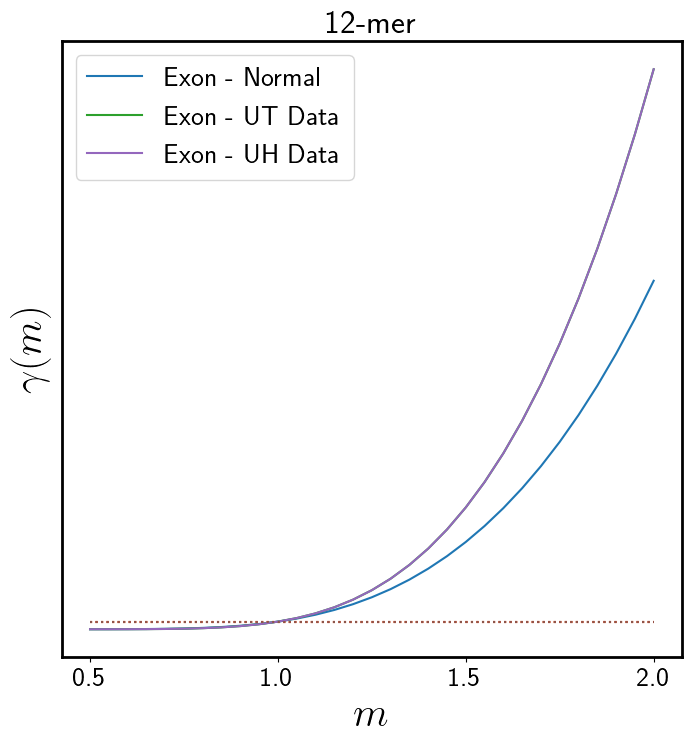

In [24]:
me = {"Normal": {"data": {6: normal_moments}, "marker": None}, "UT Data": {"data": {6: cancer_moments}, "marker": None}, "UH Data": {"data": {6: cancer_moments}, "marker": None}}

#me = {"Human": {"data": hum_me, "marker": None}, "Mouse": {"data": mou_me, "marker": None}, "Fly": {"data": fly_me, "marker": None}}

multiple_species_plots(ms, me, None, None, uni, output_dir = cwd / "TE_Images_ForPaper",
                       x_ticks = {0.5: 0.5, 1.0: 1.0, 1.5: 1.5, 2.0: 2.0},
                       filename = cwd / "TE_Images_ForPaper" / "Normal_vs_Cancer.png")